In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os
import pickle
import glob
from skimage.feature import hog
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label
import time
%matplotlib inline

Reading in and visualizing Test Images

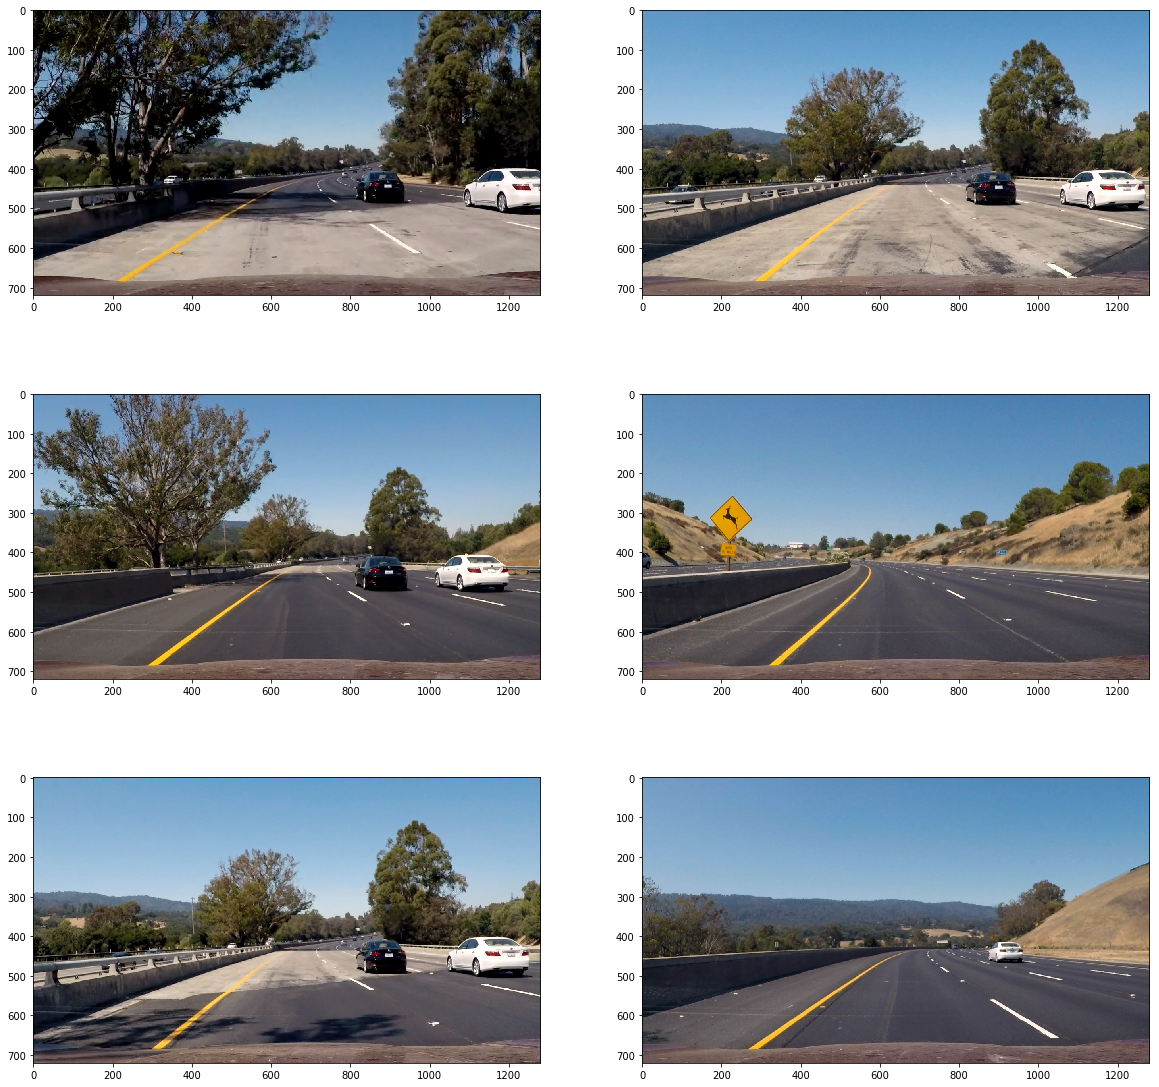

In [2]:
#Reading in all the image names

testimages=glob.glob("./test_images/*.jpg")
                                                                     
#Plotting/Visualizing
plt.figure(figsize=(20,20))
#Plotting the images
counter=1
image_test=[]
for image in testimages:
    image_test.append(mpimg.imread(image))
    plt.subplot(3,2,counter)
    plt.imshow(image_test[counter-1])
    #plt.axis('off')
    counter=counter+1
plt.show()

In [3]:
print(image_test[0].shape)

(720, 1280, 3)


Data

In [4]:
# images are divided up into vehicles and non-vehicles

cars = glob.glob("./data/vehicles/**/*.png")
notcars = glob.glob("./data/non-vehicles/**/*.png")

print("Total Car Images: ",len(cars))
print("Total Non-Car Images: ",len(notcars))

Total Car Images:  8792
Total Non-Car Images:  8968


Your function returned a count of 8792  cars and 8968  non-cars
of size:  (64, 64, 3)  and data type: float32


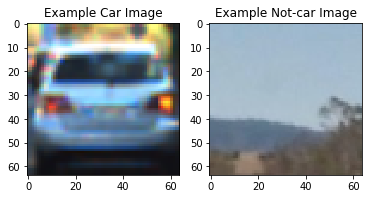

In [5]:
# Define a function to return some characteristics of the dataset 
def data_look(car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    # Read in a test image, either car or notcar
    example_img = mpimg.imread(car_list[0])
    # Define a key "image_shape" and store the test image shape 3-tuple
    data_dict["image_shape"] = example_img.shape
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = example_img.dtype
    # Return data_dict
    return data_dict
    
data_info = data_look(cars, notcars)

print('Your function returned a count of', 
      data_info["n_cars"], ' cars and', 
      data_info["n_notcars"], ' non-cars')
print('of size: ',data_info["image_shape"], ' and data type:', 
      data_info["data_type"])
# Just for fun choose random car / not-car indices and plot example images   
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))
    
# Read in car / not-car images
car_image = mpimg.imread(cars[car_ind])
notcar_image = mpimg.imread(notcars[notcar_ind])


# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(car_image)
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(notcar_image)
plt.title('Example Not-car Image')


Combine and Normalize Features

In [6]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

In [7]:
# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

In [8]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), block_norm= 'L2-Hys',
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), block_norm= 'L2-Hys',
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

In [9]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, cspace='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0, spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256)):
    # Create a list to append feature vectors to
    features = []
    for file in imgs:
        # Read in each one by one
        image = cv2.imread(file)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        else: feature_image = np.copy(image)      
        # Apply bin_spatial() to get spatial color features
        #spatial_features = bin_spatial(feature_image, size=spatial_size)
        # Apply color_hist() also with a color space option now
        #hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        #features.append(np.concatenate((spatial_features, hist_features, hog_features)))
        features.append(hog_features)
    # Return list of feature vectors
    return features


In [37]:
### TODO: Tweak these parameters and see how the results change.
colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 12#9
pix_per_cell = 18#8
cell_per_block = 3
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial = 32
histbin = 32

t1=time.time()
car_features = extract_features(cars, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_size=(spatial, spatial),
                        hist_bins=histbin, hist_range=(0, 256))
notcar_features = extract_features(notcars, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_size=(spatial, spatial),
                        hist_bins=histbin, hist_range=(0, 256))
t2 = time.time()
print(round(t2-t1, 2), 'Seconds to extract HOG features...')
print(len(car_features[0]))

71.23 Seconds to extract HOG features...
324


In [38]:
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_state)
    
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X_train)
# Apply the scaler to X
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t1=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t1, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t1=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t1, 5), 'Seconds to predict', n_predict,'labels with SVC')

Using: 12 orientations 18 pixels per cell and 3 cells per block
Feature vector length: 324
3.16 Seconds to train SVC...
Test Accuracy of SVC =  0.9749
My SVC predicts:  [ 1.  1.  0.  1.  1.  0.  1.  0.  0.  0.]
For these 10 labels:  [ 1.  1.  0.  1.  1.  0.  1.  0.  0.  0.]
0.00387 Seconds to predict 10 labels with SVC


In [33]:
# Save the classifier for later use 
svc_pickle = {}
svc_pickle["svc"] = svc
svc_pickle["scaler"] = X_scaler
svc_pickle["orient"] = orient
svc_pickle["pix_per_cell"] = pix_per_cell
svc_pickle["cell_per_block"] = cell_per_block
svc_pickle["spatial_size"] = spatial
svc_pickle["hist_bins"] = histbin
svc_pickle["colorspace"] = colorspace
svc_pickle["hog_channel"] = hog_channel
pickle.dump( svc_pickle, open( "./svc_pickle4.p", "wb" ) )


Defining a function for search

In [10]:
def bin_spatial_pipe(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))

In [11]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

In [12]:
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

In [13]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

In [14]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if conv == 'YUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YUV)

In [30]:
# load a pe-trained svc model from a serialized (pickle) file
svc_pickle = pickle.load( open("./svc_pickle.p", "rb" ) )

# get attributes of our svc object
svc = svc_pickle["svc"]
X_scaler = svc_pickle["scaler"]
orient = svc_pickle["orient"]
pix_per_cell = svc_pickle["pix_per_cell"]
cell_per_block = svc_pickle["cell_per_block"]
spatial_size = svc_pickle["spatial_size"]
hist_bins = svc_pickle["hist_bins"]
color_space = svc_pickle["colorspace"]
hog_channel = svc_pickle["hog_channel"]

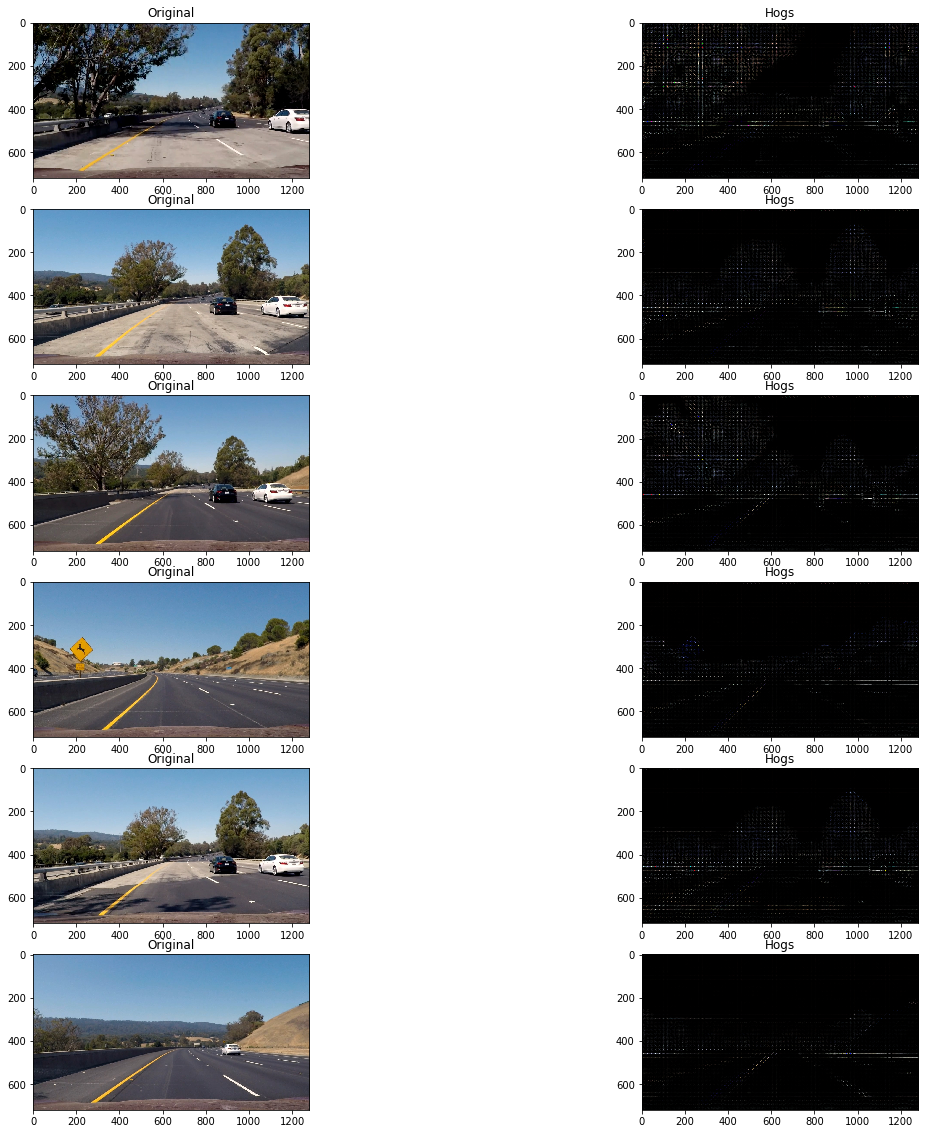

In [16]:
#Visualize Hog Features

counter1=1
plt.figure(figsize=(20,20))
for im in image_test:
    draw_it=np.copy(im)
    
    cha1 = draw_it[:,:,0]
    cha2 = draw_it[:,:,1]
    cha3 = draw_it[:,:,2]
    
    # Compute individual channel HOG features for the entire image
    
    feat1,hog_1 = get_hog_features(cha1, orient, pix_per_cell, cell_per_block, vis=True, feature_vec=False)
    feat2,hog_2 = get_hog_features(cha2, orient, pix_per_cell, cell_per_block, vis=True, feature_vec=False)
    feat3,hog_3 = get_hog_features(cha3, orient, pix_per_cell, cell_per_block, vis=True, feature_vec=False)
    feat = np.hstack((feat1, feat2, feat3))
    hog_it = np.dstack((hog_1, hog_2, hog_3))
    
    #print("Number of Features detected : ",len(feat))
    plt.subplot(6,2,counter1)
    plt.imshow(im)
    plt.title("Original")
    plt.subplot(6,2,counter1+1)
    plt.imshow(hog_it)
    plt.title("Hogs")
    counter1=counter1+2
plt.show()

In [17]:
def heat_calculation(heat, windo , thresh, draw, pipe=False):
    if(pipe==False):
        # Add heat to each box in box list
        heat = add_heat(heat,windo)
    
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,thresh)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(draw, labels)
    return heatmap, draw_img

In [18]:

# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, colorspace, thresh):
    
    draw_img1 = np.copy(img)
    crop_img = img[0:img.shape[0], 660:img.shape[1]]
    draw_img = np.copy(crop_img)
    heat = np.zeros_like(crop_img[:,:,0]).astype(np.float)
    #img = img.astype(np.float32)/255
    on_windows = []
    img_tosearch = crop_img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv=colorspace)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        #print(imshape)
        #print(np.int(imshape[1]/scale), "and", np.int(imshape[0]/scale))
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            #subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            #spatial_features = bin_spatial_pipe(subimg, size=(spatial_size[0],spatial_size[0]))
            #hist_features = color_hist(subimg, nbins=32)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack(( hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                # Calculate window position
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                #cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                on_windows.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
    #window_img = draw_boxes(draw_img, on_windows, color=(0, 0, 255), thick=6)  
    
#     # Add heat to each box in box list
#     heat = add_heat(heat,on_windows)
    
#     # Apply threshold to help remove false positives
#     #heat = apply_threshold(heat,1)

#     # Visualize the heatmap when displaying    
#     heatmap = np.clip(heat, 0, 255)

#     # Find final boxes from heatmap using label function
#     labels = label(heatmap)
#     draw_img = draw_labeled_bboxes(draw_img, labels)
    
    heatmap, draw_img= heat_calculation(heat, on_windows , thresh, draw_img, pipe=False)
    
    draw_img1[0:draw_img1.shape[0], 660:draw_img1.shape[1]] = draw_img
    return on_windows, heatmap, draw_img1
    

In [19]:
# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
# def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
#                         hist_bins=32, orient=9, 
#                         pix_per_cell=8, cell_per_block=2, hog_channel=0,
#                         spatial_feat=True, hist_feat=True, hog_feat=True):    
#     #1) Define an empty list to receive features
#     img_features = []
#     #2) Apply color conversion if other than 'RGB'
#     if color_space != 'RGB':
#         if color_space == 'HSV':
#             feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
#         elif color_space == 'LUV':
#             feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
#         elif color_space == 'HLS':
#             feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
#         elif color_space == 'YUV':
#             feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
#         elif color_space == 'YCrCb':
#             feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
#     else: feature_image = np.copy(img)      
#     #3) Compute spatial features if flag is set
#     if spatial_feat == True:
#         spatial_features = bin_spatial(feature_image, size=(spatial_size,spatial_size))
#         #4) Append features to list
#         img_features.append(spatial_features)
#     #5) Compute histogram features if flag is set
#     if hist_feat == True:
#         hist_features = color_hist(feature_image, nbins=hist_bins)
#         #6) Append features to list
#         img_features.append(hist_features)
#     #7) Compute HOG features if flag is set
#     if hog_feat == True:
#         if hog_channel == 'ALL':
#             hog_features = []
#             for channel in range(feature_image.shape[2]):
#                 hog_features.extend(get_hog_features(feature_image[:,:,channel], 
#                                     orient, pix_per_cell, cell_per_block, 
#                                     vis=False, feature_vec=True))      
#         else:
#             hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
#                         pix_per_cell, cell_per_block, vis=False, feature_vec=True)
#         #8) Append features to list
#         img_features.append(hog_features)

#     #9) Return concatenated array of features
#     return np.concatenate(img_features)

# # Define a function you will pass an image 
# # and the list of windows to be searched (output of slide_windows())
# def search_windows(img, windows, clf, scaler, color_space='RGB', 
#                     spatial_size=(32, 32), hist_bins=32, 
#                     hist_range=(0, 256), orient=9, 
#                     pix_per_cell=8, cell_per_block=2, 
#                     hog_channel=0, spatial_feat=True, 
#                     hist_feat=True, hog_feat=True):

#     #1) Create an empty list to receive positive detection windows
#     on_windows = []
#     #2) Iterate over all windows in the list
#     for window in windows:
#         #3) Extract the test window from original image
#         test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
#         #4) Extract features for that window using single_img_features()
#         features = single_img_features(test_img, color_space=color_space, 
#                             spatial_size=spatial_size, hist_bins=hist_bins, 
#                             orient=orient, pix_per_cell=pix_per_cell, 
#                             cell_per_block=cell_per_block, 
#                             hog_channel=hog_channel, spatial_feat=spatial_feat, 
#                             hist_feat=hist_feat, hog_feat=hog_feat)
#         #5) Scale extracted features to be fed to classifier
#         test_features = scaler.transform(np.array(features).reshape(1, -1))
#         #6) Predict using your classifier
#         prediction = clf.predict(test_features)
#         #7) If positive (prediction == 1) then save the window
#         if prediction == 1:
#             on_windows.append(window)
#     #8) Return windows for positive detections
#     return on_windows

# # Define a function that takes an image,
# # start and stop positions in both x and y, 
# # window size (x and y dimensions),  
# # and overlap fraction (for both x and y)
# def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
#                     xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
#     # If x and/or y start/stop positions not defined, set to image size
#     if x_start_stop[0] == None:
#         x_start_stop[0] = 0
#     if x_start_stop[1] == None:
#         x_start_stop[1] = img.shape[1]
#     if y_start_stop[0] == None:
#         y_start_stop[0] = 0
#     if y_start_stop[1] == None:
#         y_start_stop[1] = img.shape[0]
#     # Compute the span of the region to be searched    
#     xspan = x_start_stop[1] - x_start_stop[0]
#     yspan = y_start_stop[1] - y_start_stop[0]
#     # Compute the number of pixels per step in x/y
#     nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
#     ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
#     # Compute the number of windows in x/y
#     nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
#     ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
#     nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
#     ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
#     # Initialize a list to append window positions to
#     window_list = []
#     # Loop through finding x and y window positions
#     # Note: you could vectorize this step, but in practice
#     # you'll be considering windows one by one with your
#     # classifier, so looping makes sense
#     for ys in range(ny_windows):
#         for xs in range(nx_windows):
#             # Calculate window position
#             startx = xs*nx_pix_per_step + x_start_stop[0]
#             endx = startx + xy_window[0]
#             starty = ys*ny_pix_per_step + y_start_stop[0]
#             endy = starty + xy_window[1]
            
#             # Append window position to list
#             window_list.append(((startx, starty), (endx, endy)))
#     # Return the list of windows
#     return window_list

Number of Windows detected :  4
Number of Windows detected :  4
Number of Windows detected :  3
Number of Windows detected :  0
Number of Windows detected :  3
Number of Windows detected :  1


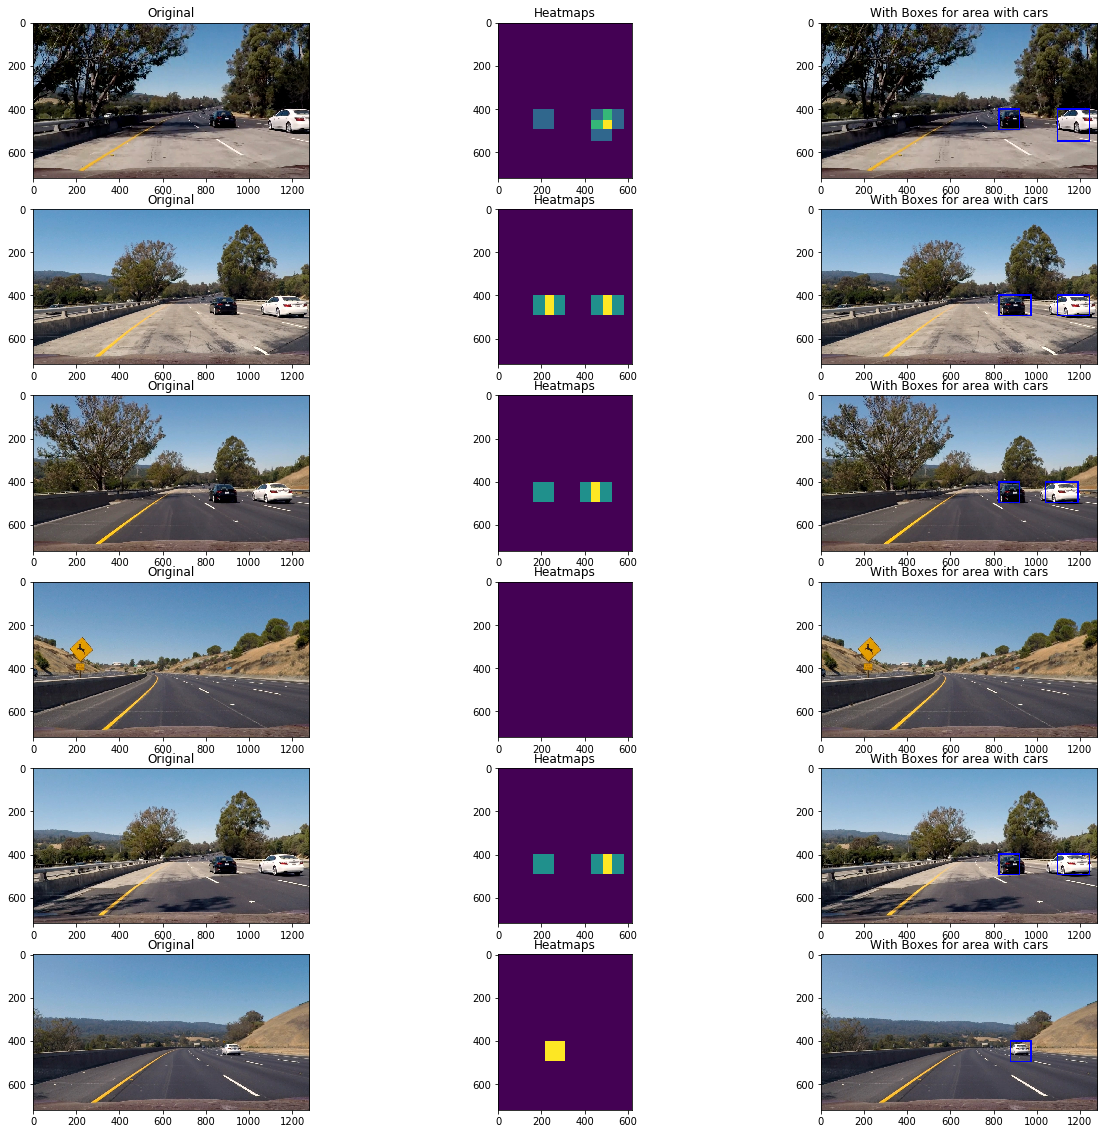

In [20]:
ystart = 400
ystop = 656
scale = 1.5

counter1=1
plt.figure(figsize=(20,20))
for pic in image_test:
    draw_image=np.copy(pic)
    bboxes, heat_img, out_img = find_cars(pic, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, (spatial_size, spatial_size), hist_bins, color_space, 0)
    print("Number of Windows detected : ",len(bboxes))
    plt.subplot(6,3,counter1)
    plt.imshow(pic)
    plt.title("Original")
    plt.subplot(6,3,counter1+1)
    plt.imshow(heat_img)
    plt.title("Heatmaps")
    plt.subplot(6,3,counter1+2)
    plt.imshow(out_img)
    plt.title("With Boxes for area with cars")
    counter1=counter1+3
plt.show()

Number of Windows detected :  7
Number of Windows detected :  7
Number of Windows detected :  6
Number of Windows detected :  0
Number of Windows detected :  7
Number of Windows detected :  1


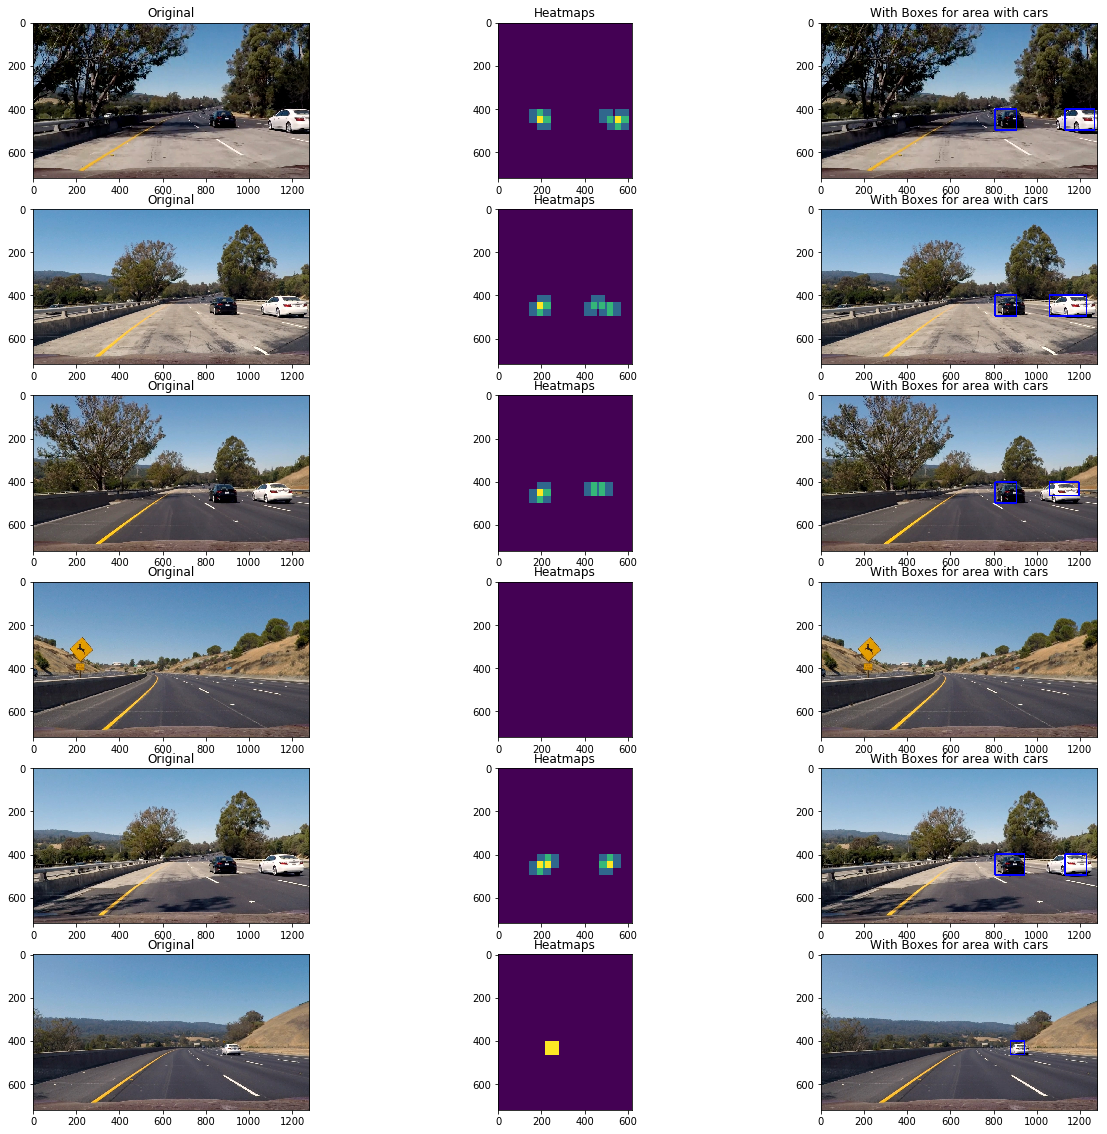

In [21]:
ystart = 400
ystop = 500
scale = 1

counter1=1
plt.figure(figsize=(20,20))
for pic in image_test:
    draw_image=np.copy(pic)
    bboxes, heat_img, out_img = find_cars(pic, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, (spatial_size, spatial_size), hist_bins, color_space, 0)
    print("Number of Windows detected : ",len(bboxes))
    plt.subplot(6,3,counter1)
    plt.imshow(pic)
    plt.title("Original")
    plt.subplot(6,3,counter1+1)
    plt.imshow(heat_img)
    plt.title("Heatmaps")
    plt.subplot(6,3,counter1+2)
    plt.imshow(out_img)
    plt.title("With Boxes for area with cars")
    counter1=counter1+3
plt.show()

Number of Windows detected :  2
Number of Windows detected :  2
Number of Windows detected :  2
Number of Windows detected :  0
Number of Windows detected :  2
Number of Windows detected :  1


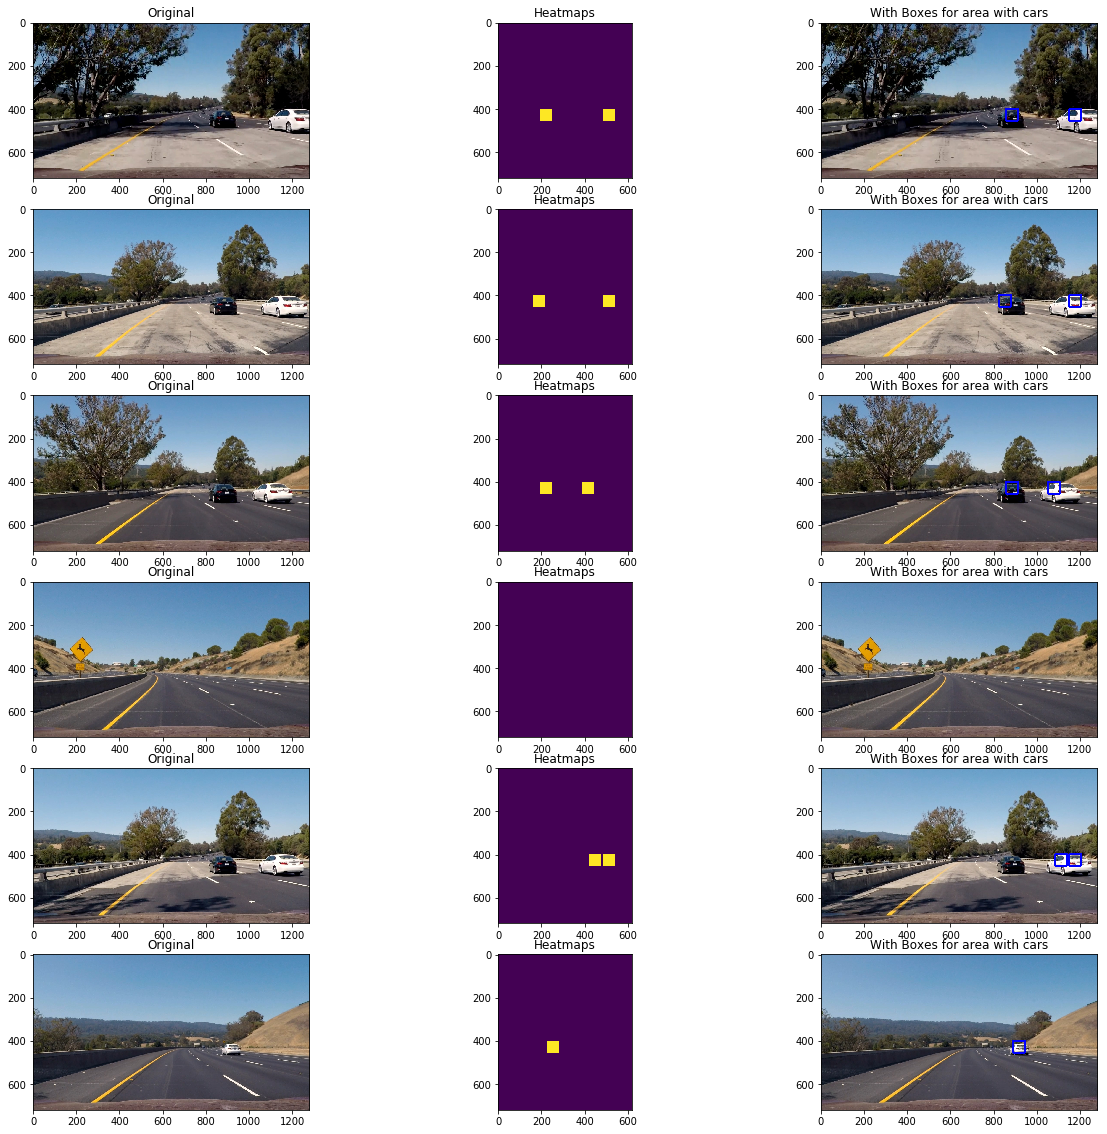

In [22]:
ystart = 400
ystop = 450
scale = 0.9

counter1=1
plt.figure(figsize=(20,20))
for pic in image_test:
    draw_image=np.copy(pic)
    bboxes, heat_img, out_img = find_cars(pic, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, (spatial_size, spatial_size), hist_bins, color_space, 0)
    print("Number of Windows detected : ",len(bboxes))
    plt.subplot(6,3,counter1)
    plt.imshow(pic)
    plt.title("Original")
    plt.subplot(6,3,counter1+1)
    plt.imshow(heat_img)
    plt.title("Heatmaps")
    plt.subplot(6,3,counter1+2)
    plt.imshow(out_img)
    plt.title("With Boxes for area with cars")
    counter1=counter1+3
plt.show()

In [23]:
# ystart = 400
# ystop = 656
# scale = 1.5
# # color_space = 'YCrCb'
# # spatial_feat = True # Spatial features on or off
# # hist_feat = True # Histogram features on or off
# # hog_feat = True # HOG features on or off


# counter1=1
# plt.figure(figsize=(20,20))
# for pic in image_test:
#     draw_image=np.copy(pic)
#     windows = slide_window(pic, x_start_stop=[700, None], y_start_stop=[ystart, ystop], 
#                     xy_window=(64, 64), xy_overlap=(0.5, 0.5))

#     hot_windows = search_windows(pic, windows, svc, X_scaler, color_space=color_space, 
#                         spatial_size=spatial_size, hist_bins=hist_bins, 
#                         orient=orient, pix_per_cell=pix_per_cell, 
#                         cell_per_block=cell_per_block, 
#                         hog_channel=hog_channel, spatial_feat=spatial_feat, 
#                         hist_feat=hist_feat, hog_feat=hog_feat)                       

#     window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

#     #bboxes, out_img = find_cars(pic, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, (spatial_size, spatial_size), hist_bins)
#     #print("Number of Windows detected : ",len(bboxes))
#     plt.subplot(6,2,counter1)
#     plt.imshow(pic)
#     plt.title("Original")
#     plt.subplot(6,2,counter1+1)
#     plt.imshow(window_img)
#     plt.title("With Boxes for area with cars")
#     counter1=counter1+2
# plt.show()

Defining a pipeline

In [24]:
from collections import deque

frame_hist=deque(maxlen=9)

def pipeline(img):
    on_windows=[]
    ystart1 = 400
    ystop1 = 656
    scale1 = 1.5
    
    draw_img1 = np.copy(img)
    crop_img = img[0:img.shape[0], 660:img.shape[1]]
    draw_img = np.copy(crop_img)
    heat = np.zeros_like(crop_img[:,:,0]).astype(np.float)
    
    bboxes1, heat_img, out_img = find_cars(draw_img1, ystart1, ystop1, scale1, svc, X_scaler, orient, pix_per_cell, cell_per_block, (spatial_size, spatial_size), hist_bins, color_space, 0)
    
    ystart2 = 400
    ystop2 = 500
    scale2 = 1
    
    bboxes2, heat_img, out_img = find_cars(draw_img1, ystart2, ystop2, scale2, svc, X_scaler, orient, pix_per_cell, cell_per_block, (spatial_size, spatial_size), hist_bins, color_space, 0)
    
    ystart3 = 400
    ystop3 = 450
    scale3 = 0.9
    
    bboxes3, heat_img, out_img = find_cars(draw_img1, ystart3, ystop3, scale3, svc, X_scaler, orient, pix_per_cell, cell_per_block, (spatial_size, spatial_size), hist_bins, color_space, 0)
    
    ystart4 = 450
    ystop4 = 500
    scale4 = 0.9
    
    bboxes4, heat_img, out_img = find_cars(draw_img1, ystart4, ystop4, scale4, svc, X_scaler, orient, pix_per_cell, cell_per_block, (spatial_size, spatial_size), hist_bins, color_space, 0)
    
#     ystart5 = 500
#     ystop5 = 550
#     scale5 = 0.9
    
#     bboxes5, heat_img, out_img = find_cars(draw_img1, ystart5, ystop5, scale5, svc, X_scaler, orient, pix_per_cell, cell_per_block, (spatial_size, spatial_size), hist_bins, color_space, 0)
    
    on_windows = bboxes1+bboxes2+bboxes3+bboxes4#+bboxes5
    
    heat = add_heat(heat, on_windows)
    
    frame_hist.append(heat)
    
    #heat = np.array(frame_hist).sum(axis=0)
    heat = np.mean(np.array(frame_hist), axis=0)
    
    heatmap, draw_img= heat_calculation(heat, on_windows , 3, draw_img)
    
    draw_img1[0:draw_img1.shape[0], 660:draw_img1.shape[1]] = draw_img
    
    return draw_img1

In [25]:
#Pipeline Function
# font = cv2.FONT_HERSHEY_SIMPLEX
# def pipeline(img):
#     win, pipe_heat, pipe_img = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, (spatial_size, spatial_size), hist_bins, color_space,1)
#     #small = cv2.resize(pipe_heat, (180,320)) 
#     #small = np.dstack((small, small, small))
#     #pipe_img[0:320, 0:180] = small
#     #text=str(win)+' windows detected'
#     #cv2.putText(pipe_img, text, (640, 100), font, 0.5, (0, 0, 0), 2, cv2.LINE_AA)
#     return pipe_img

In [26]:
#Testing on Video
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

video_output = './test_videos_output/project_video_output9.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip = VideoFileClip("./project_video.mp4") #.subclip(8,13)
pipe_clip = clip.fl_image(pipeline) #NOTE: this function expects color images!!
%time pipe_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video ./test_videos_output/project_video_output9.mp4
[MoviePy] Writing video ./test_videos_output/project_video_output9.mp4


100%|█████████▉| 1260/1261 [10:44<00:00,  1.96it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./test_videos_output/project_video_output9.mp4 

CPU times: user 11min 14s, sys: 1.61 s, total: 11min 16s
Wall time: 10min 44s
